In [1]:
import model_feedinput_pipeline
import autoencoder_lstm_generate_features as ae_timefeatures

from model_feedinput_pipeline import CODE_ENV, DATASET_ID

In [2]:
import os
import joblib
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
from numpy.random import seed
seed(10)

import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

from scipy.stats import entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.random.set_seed(10)
#tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers



In [3]:
def scale_timefeature_data(X_train, X_test):
    # normalize the data
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    return scaled_X_train, scaled_X_test


def prepare_lstm_input(X_train, X_test):
    # reshape inputs for LSTM [samples, timesteps, features]
    X_train_out = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_out = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train_out, X_test_out


# define the autoencoder network model
def autoencoder_model(X_train):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X_train.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X_train.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mae')
    
    return model


def train_autoencoder(model, X_train):
    nb_epochs = 100
    batch_size = 10
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history
    return model, history


def train_autoencoder_main(time_features_data:pd.DataFrame, cut_off_date_time:str):

    #Step 1 : Re-construct the index columns 'date_time'    
    #print(time_features_data.describe().T)
    #print(time_features_data.columns)
    time_features_data=time_features_data.rename(columns={'filename':'date_time'})
    time_features_data['date_time']=pd.to_datetime(time_features_data['date_time'])   
    
    #Step 2 : Prepare Train, Validation and Test test
    train = time_features_data[time_features_data['date_time'] <= cut_off_date_time]
    test  = time_features_data[time_features_data['date_time'] > cut_off_date_time]
    train = train.set_index('date_time')
    test  = test.set_index('date_time')

    #Step 3 : Prepare Data : Normalize & Reshape
    X_train, X_test = scale_timefeature_data(train, test)
    X_train, X_test = prepare_lstm_input(X_train, X_test)

    #Step 4 : Build the model
    model = autoencoder_model(X_train)

    #Step 5: Train the model
    history = ''
    model, history = train_autoencoder(model, X_train)

    return train, test, X_train, X_test, model, history


def pred_train_autoencoder(model, X_train, train):
    
    # calculate the loss on the test set
    X_train_pred = model.predict(X_train)
    X_train_pred = X_train_pred.reshape(X_train_pred.shape[0], X_train_pred.shape[2])

    X_train_pred = pd.DataFrame(X_train_pred, columns=train.columns)
    X_train_pred.index = train.index

    train_scored = pd.DataFrame(index=train.index)
    XTrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
    train_scored['Loss_mae'] = np.mean(np.abs(X_train_pred-XTrain), axis = 1)
    threshold = min(train_scored['Loss_mae']) + (max(train_scored['Loss_mae']) - min(train_scored['Loss_mae'])) * 0.8
    print('Chosen Threshold =', threshold)
    train_scored['Threshold'] = threshold
    train_scored['Anomaly'] = train_scored['Loss_mae'] > train_scored['Threshold']
    return train_scored, X_train_pred, XTrain, threshold


def pred_test_autoencoder(model, X_test, test, threshold):
    
    # calculate the loss on the test set
    X_test_pred = model.predict(X_test)
    X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
    
    X_test_pred = pd.DataFrame(X_test_pred, columns=test.columns)
    X_test_pred.index = test.index

    test_scored = pd.DataFrame(index=test.index)
    XTest = X_test.reshape(X_test.shape[0], X_test.shape[2])
    test_scored['Loss_mae'] = np.mean(np.abs(X_test_pred-XTest), axis = 1)
    test_scored['Threshold'] = threshold
    test_scored['Anomaly'] = test_scored['Loss_mae'] > test_scored['Threshold']
    return test_scored, X_test_pred, XTest



In [4]:
#####################################################################################
#***************IMP: Update coding environment********************
#####################################################################################
code_env = CODE_ENV.WSL
curr_dataset = DATASET_ID.Second

#Step 1 : Setup Data Source
dataset_paths = model_feedinput_pipeline.get_dataset_paths(code_env)   

#Step 2 : Read the time features generated earlier
time_feature_data_filename=['timefeatures_1st_1.csv', 'timefeatures_1st_2.csv',
                            'timefeatures_2nd.csv', 'timefeatures_3rd.csv']

tf_file_indx = 0
cut_off_date_time = '2003-11-20 23:54:03'
if curr_dataset == DATASET_ID.First:
    tf_file_indx = 0 #0 or 1
    cut_off_date_time = '2003-11-20 23:54:03'
elif curr_dataset == DATASET_ID.Second:
    tf_file_indx = 2
    cut_off_date_time = '2004-02-15 12:52:39'
elif curr_dataset == DATASET_ID.Third:
    tf_file_indx = 3
    cut_off_date_time = '2004-04-08 23:51:57'

time_features_data = pd.read_csv(time_feature_data_filename[tf_file_indx])

train, test, X_train, X_test, model, history = train_autoencoder_main(time_features_data, cut_off_date_time)

# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
train_scored, X_train_pred, XTrain, threshold = pred_train_autoencoder(model, X_train, train)

test_scored, X_test_pred, XTest = pred_test_autoencoder(model, X_test, test, threshold)


2023-04-18 22:58:41.036772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
43/43 [==============================] - 4s 19ms/step - loss: 0.7828 - val_loss: 0.7630
Epoch 2/100
43/43 [==============================] - 0s 6ms/step - loss: 0.7814 - val_loss: 0.7633
Epoch 3/100
43/43 [==============================] - 0s 6ms/step - loss: 0.7795 - val_loss: 0.7634
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.7707 - val_loss: 0.7609
Epoch 5/100
43/43 [==============================] - 0s 6ms/step - loss: 0.7476 - val_loss: 0.7531
Epoch 6/100
43/43 [==============================] - 0s 8ms/step - loss: 0.7356 - val_loss: 0.7361
Epoch 7/100
43/43 [==============================] - 0s 7ms/step - loss: 0.7150 - val_loss: 0.6974
Epoch 8/100
43/43 [==============================] - 0s 6ms/step - loss: 0.6995 - val_loss: 0.6889
Epoch 9/100
43/43 [==============================] - 0s 6ms/step - loss: 0.6913 - val_loss: 0.6819
Epoch 10/100
43/43 [==============================] - 0s 10ms/step - loss: 0.6865 - val_loss: 0.6787
Epoch 1

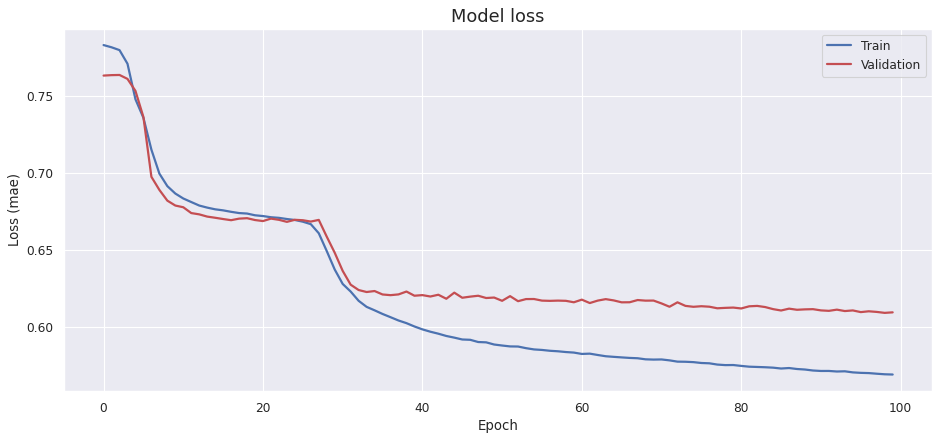

In [5]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

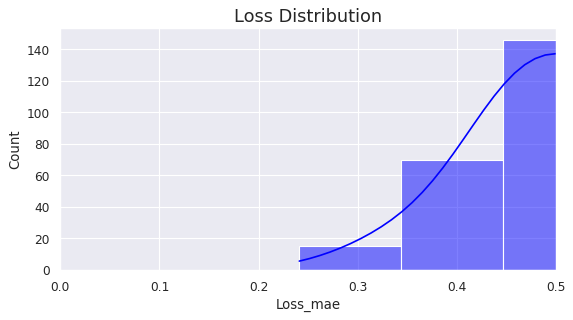

In [6]:
plt.figure(figsize=(8,4), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(train_scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

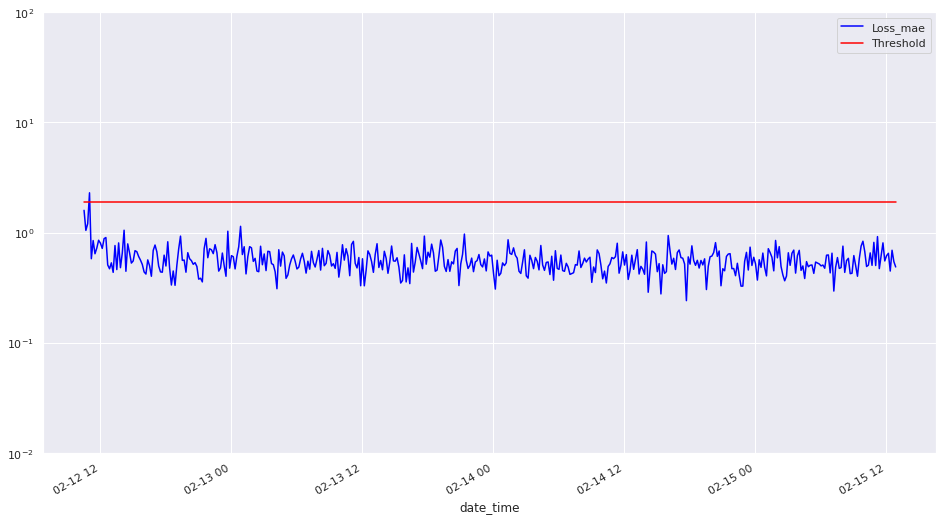

In [7]:
train_scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
plt.show()

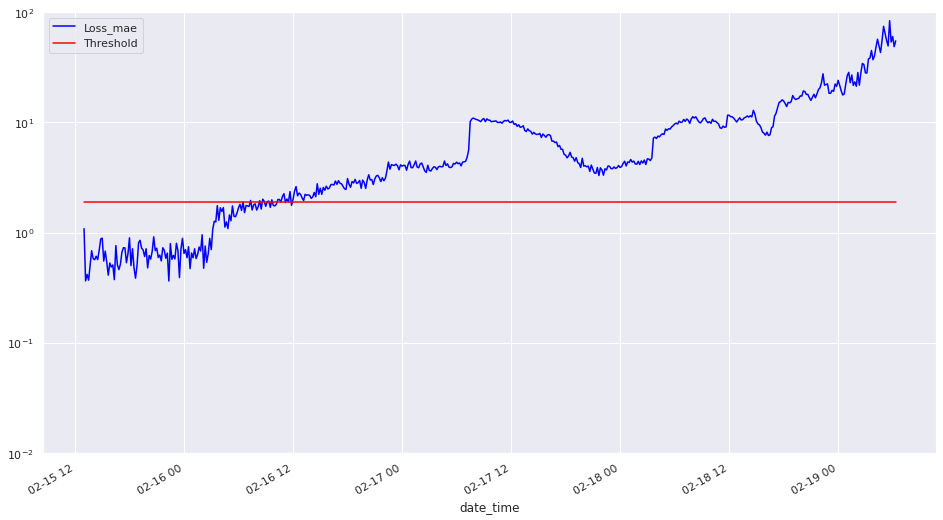

In [8]:
# plot bearing failure time plot
test_scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
plt.show()

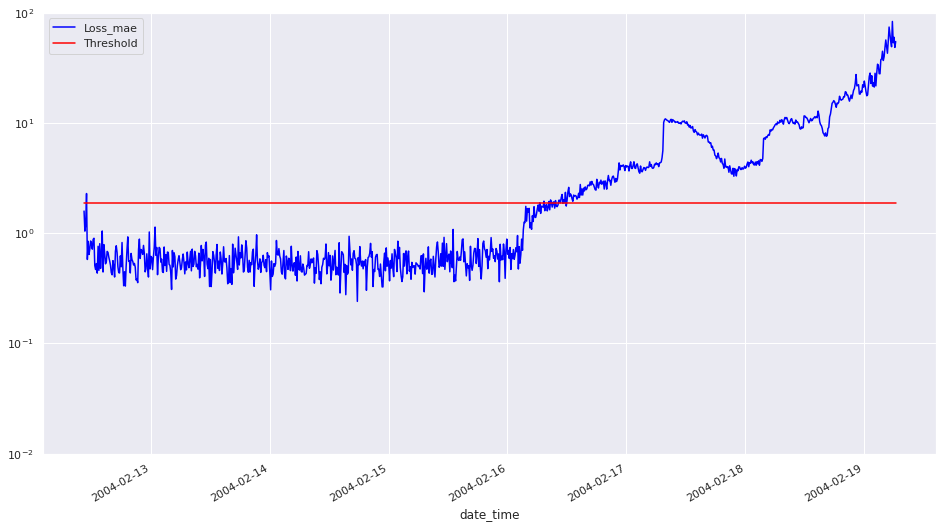

In [9]:
scored = pd.concat([train_scored, test_scored])
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
plt.show()

Threshold = 1.8857563541853657
40/40 [==============================] - 0s 3ms/step


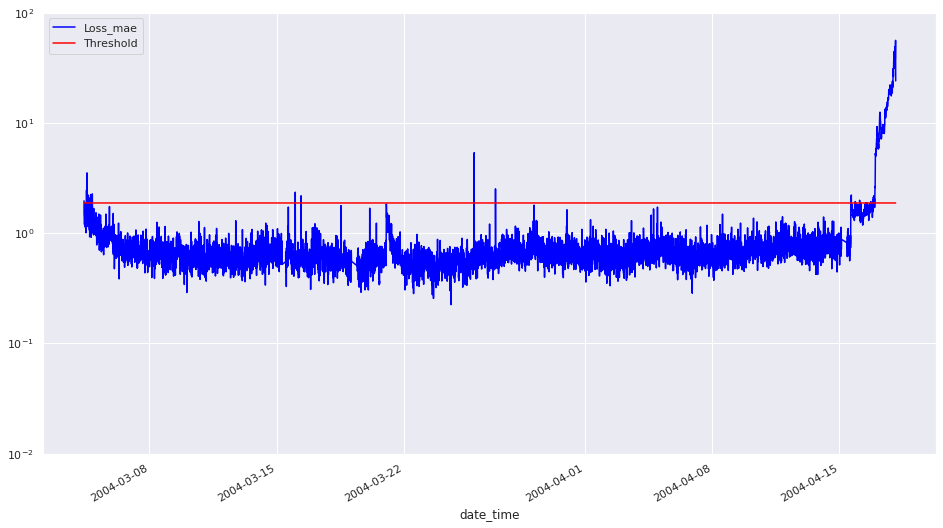

In [28]:
#####################################################################################
#***************IMP: Update coding environment********************
#####################################################################################
code_env = CODE_ENV.WSL
curr_dataset = DATASET_ID.Third

#Step 1 : Setup Data Source
dataset_paths = model_feedinput_pipeline.get_dataset_paths(code_env)   

#Step 2 : Read the time features generated earlier
time_feature_data_filename=['timefeatures_1st_1.csv', 'timefeatures_1st_2.csv',
                            'timefeatures_2nd.csv', 'timefeatures_3rd.csv']

tf_file_indx = 0
cut_off_date_time = '2003-11-20 23:54:03'
if curr_dataset == DATASET_ID.First:
    tf_file_indx = 1 #0 or 1
    cut_off_date_time = '2003-11-20 23:54:03'
elif curr_dataset == DATASET_ID.Second:
    tf_file_indx = 2
    cut_off_date_time = '2004-02-15 12:52:39'
elif curr_dataset == DATASET_ID.Third:
    tf_file_indx = 3
    cut_off_date_time = '2004-04-08 23:51:57'

time_features_data = pd.read_csv(time_feature_data_filename[tf_file_indx])

#Step 1 : Re-construct the index columns 'date_time'    
#print(time_features_data.describe().T)
#print(time_features_data.columns)
time_features_data=time_features_data.rename(columns={'filename':'date_time'})
time_features_data['date_time']=pd.to_datetime(time_features_data['date_time'])   

#Step 2 : Prepare Train, Validation and Test test
train = time_features_data[time_features_data['date_time'] <= cut_off_date_time]
test  = time_features_data[time_features_data['date_time'] > cut_off_date_time]
train = train.set_index('date_time')
test  = test.set_index('date_time')

#Step 3 : Prepare Data : Normalize & Reshape
X_train, X_test = scale_timefeature_data(train, test)
X_train, X_test = prepare_lstm_input(X_train, X_test)

print('Threshold =', threshold)
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
test_scored1, X_test_pred1, XTest1 = pred_test_autoencoder(model, X_train, train, threshold)
test_scored2, X_test_pred2, XTest2 = pred_test_autoencoder(model, X_test, test, threshold)
scored = pd.concat([test_scored1, test_scored2])

# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
plt.show()
